## Виконання роботи

In [1]:
import numpy as np
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl

from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [2]:
# Вхідні дані
coord_start, coord_stop = -2, 3

In [3]:
# Плавний графік функції
long_x = np.linspace(coord_start, coord_stop, 60)
long_y = long_x.copy()

long_X, long_Y = np.meshgrid(long_x, long_y)
long_Z = long_X * np.cos(long_Y) + np.sin(long_X)

fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=long_Z)])

fig.update_layout(title='Z = X * cos(Y) + sin(X) -- плавний',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

### 1. Побудувати нечітку модель функції двох змінних згідно з варіантом, що містить 6 функцій приналежності для вхідних змінних і не менше 9 для вихідної. 


In [4]:
# Дискретні дані:
n_coords = 6
x = np.linspace(coord_start, coord_stop, n_coords)
y = x.copy()
y=np.linspace(coord_start, coord_stop, n_coords)

In [5]:
# Вихідна функція
X, Y = np.meshgrid(x, y)
Z = X * np.cos(Y) + np.sin(X)

In [6]:
# Значення функції
df = pd.DataFrame(Z)
df.columns = x
df.index = y
df.columns.name = 'x'
df.index.name = 'y'

df

x,-2.0,-1.0,0.0,1.0,2.0,3.0
y,,,,,,
-2.0,-0.077004,-0.425324,0.0,0.425324,0.077004,-1.107321
-1.0,-1.989902,-1.381773,0.0,1.381773,1.989902,1.762027
0.0,-2.909297,-1.841471,0.0,1.841471,2.909297,3.141120
1.0,-1.989902,-1.381773,0.0,1.381773,1.989902,1.762027
2.0,-0.077004,-0.425324,0.0,0.425324,0.077004,-1.107321
3.0,1.070688,0.148522,0.0,-0.148522,-1.070688,-2.828857


In [7]:
# Графік функції
fig = go.Figure(data=[go.Surface(x=x, y=y, z=Z)])

fig.update_layout(title='Z = X * cos(Y) + sin(X)',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [8]:
# Creating membership functions

min_mf, max_mf = -3, 3.2

mx = ctrl.Antecedent(np.linspace(coord_start, coord_stop, 101), "mx")  # (101-1)⋮(6-1)
my = ctrl.Antecedent(np.linspace(coord_start, coord_stop, 101), "my")
mf = ctrl.Consequent(np.linspace(min_mf, max_mf , 97), "mf")  # (97-1)⋮(9-1)

# Triangle membership functions:
mx.automf(6, names=[f'mx{i}' for i in range(6)])
my.automf(6, names=[f'my{i}' for i in range(6)])
mf.automf(9, names=[f'mf{i}' for i in range(9)])

/Users/Vladimir/.pyenv/versions/3.10.0/lib/python3.10/site-packages/skfuzzy/control/fuzzyvariable.py:122: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



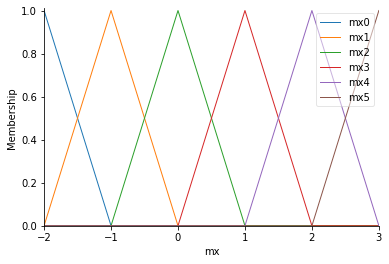

In [9]:
mx.view()

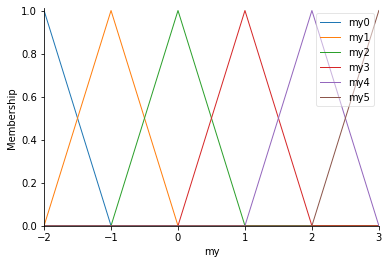

In [10]:
my.view()

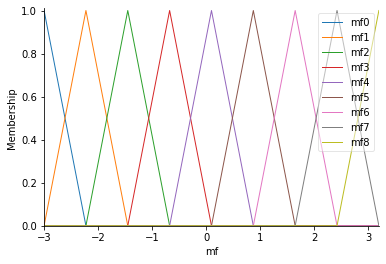

In [11]:
mf.view()

In [12]:
# Choosing the membership function with the max. membership (for mf):
mf_n_steps = (9-1) * 2
mf_step = (max_mf - min_mf) / mf_n_steps
mf_bins = np.arange(1, mf_n_steps, 2) * mf_step + min_mf  # breakpoints (where the maximum mf changes)
# Usage: `np.digitize(arr, mf_bins)`

# Testing:
ground_truth = np.array([term.mf for term in mf.terms.values()]).argmax(axis=0)
my_approach = np.digitize(mf.universe, mf_bins)
print((ground_truth == my_approach).all())

True


In [13]:
# Show max membership functions of Z:
Z_mf = np.digitize(Z.flatten(), mf_bins).reshape(Z.shape)
print(Z_mf)

[[4 3 4 4 4 2]
 [1 2 4 6 6 6]
 [0 1 4 6 8 8]
 [1 2 4 6 6 6]
 [4 3 4 4 4 2]
 [5 4 4 4 2 0]]


In [14]:
# Plot max membership functions of Z:
fig = go.Figure(data=[go.Surface(z=Z_mf)])

fig.update_layout(title='max membership functions of Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(scene = dict(
    xaxis_title="mx", yaxis_title="my", zaxis_title="mf"
))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [15]:
rules = []
for n_mf in range(9):
    # pairs of indice positions of Z_mf where Z_mf == n_mf:
    y_indices, x_indices = (Z_mf == n_mf).nonzero()
    if x_indices.size == 0:
        # no mf, so no rule for it
        continue
    
    # The antecedent:
    x_ind, y_ind = x_indices[0], y_indices[0]
    antecedent = mx[f'mx{x_ind}'] & my[f'my{y_ind}']
    for x_ind, y_ind in zip(x_indices[1:], y_indices[1:]):
        antecedent |= mx[f'mx{x_ind}'] & my[f'my{y_ind}']
        
    # The consequent:
    consequent = mf[f'mf{n_mf}']

    rule = ctrl.Rule(antecedent=antecedent,
                     consequent=consequent, 
                     label=f'rule mf{n_mf}')
    rules.append(rule)

In [16]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system)

In [19]:
new_Z = np.zeros((len(long_y), len(long_x)))
for j in range(len(long_y)):
    for i in range(len(long_x)):
        sim.inputs({'mx': long_x[i], 'my': long_y[j]})
        sim.compute()
        new_Z[j, i] = sim.output['mf']

In [20]:
# Графік
fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=new_Z)])

fig.update_layout(title='new_Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [21]:
# Діагональ (assuming x == y):
diag_Z = np.diag(long_Z)
diag_new_Z = np.diag(new_Z)
errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
error = round(errors.mean(), 3)

print('Error:', error, '%')

Error: 7.28 %


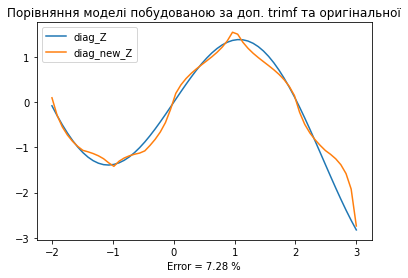

In [22]:
plt.plot(long_x, diag_Z)
plt.plot(long_x, diag_new_Z)
plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
plt.xlabel(f"Error = {error} %")
plt.legend(['diag_Z', 'diag_new_Z'])
plt.show()

### 2. Дослідити вплив форми функції приналежності (трикутник, трапеція, Гауса) на якість моделювання (порівняти відносні помилки моделювання). 

# New membership functions:

### Trapezoid membership functions

In [23]:
# Trapezoid is given by 4 points: a, b, c, d

# mx and my:
centers = np.linspace(coord_start, coord_stop, 6)  # the center points of trapezoids
coord_step = centers[1] - centers[0]  # distance between the adjacent centers
a_points = centers - coord_step
b_points = centers - coord_step / 6
c_points = centers + coord_step / 6
d_points = centers + coord_step
for i, (a, b, c, d) in enumerate(zip(a_points, b_points, c_points, d_points)):
    mx[f'mx{i}'] = fuzz.trapmf(mx.universe, [a, b, c, d])
    my[f'my{i}'] = fuzz.trapmf(my.universe, [a, b, c, d])

# mf:
centers = np.linspace(min_mf, max_mf, 9)
coord_step = centers[1] - centers[0]
a_points = centers - coord_step
b_points = centers - coord_step / 6
c_points = centers + coord_step / 6
d_points = centers + coord_step
for i, (a, b, c, d) in enumerate(zip(a_points, b_points, c_points, d_points)):
    mf[f'mf{i}'] = fuzz.trapmf(mf.universe, [a, b, c, d])

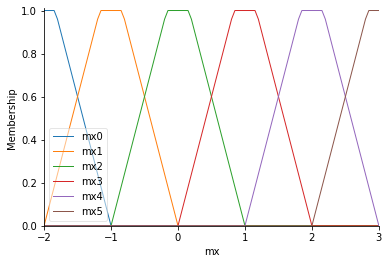

In [24]:
mx.view()

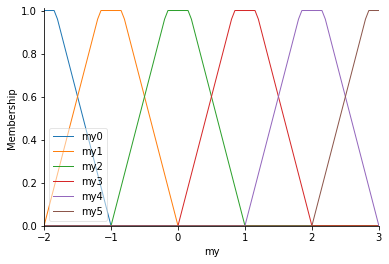

In [25]:
my.view()

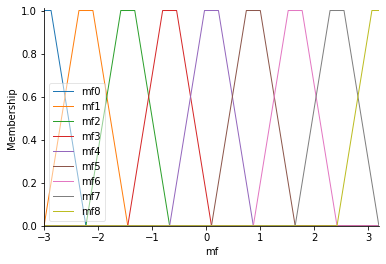

In [26]:
mf.view()

In [27]:
rules = []
for n_mf in range(9):
    # pairs of indice positions of Z_mf where Z_mf == n_mf:
    y_indices, x_indices = (Z_mf == n_mf).nonzero()
    if x_indices.size == 0:
        # no mf, so no rule for it
        continue
    
    # The antecedent:
    x_ind, y_ind = x_indices[0], y_indices[0]
    antecedent = mx[f'mx{x_ind}'] & my[f'my{y_ind}']
    for x_ind, y_ind in zip(x_indices[1:], y_indices[1:]):
        antecedent |= mx[f'mx{x_ind}'] & my[f'my{y_ind}']
        
    # The consequent:
    consequent = mf[f'mf{n_mf}']

    rule = ctrl.Rule(antecedent=antecedent,
                     consequent=consequent, 
                     label=f'rule mf{n_mf}')
    rules.append(rule)

In [28]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system)

In [29]:
new_Z = np.zeros((len(long_y), len(long_x)))
for j in range(len(long_y)):
    for i in range(len(long_x)):
        sim.inputs({'mx': long_x[i], 'my': long_y[j]})
        sim.compute()
        new_Z[j, i] = sim.output['mf']

In [30]:
# Графік
fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=new_Z)])

fig.update_layout(title='new_Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [31]:
# Діагональ (assuming x == y):
diag_Z = np.diag(long_Z)
diag_new_Z = np.diag(new_Z)
errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
error = round(errors.mean(), 3)

print('Error:', error, '%')

Error: 7.323 %


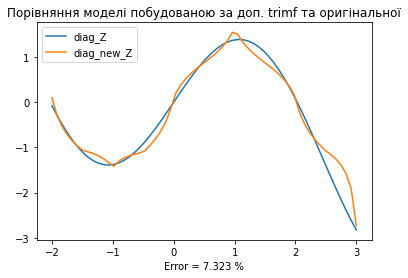

In [32]:
plt.plot(long_x, diag_Z)
plt.plot(long_x, diag_new_Z)
plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
plt.xlabel(f"Error = {error} %")
plt.legend(['diag_Z', 'diag_new_Z'])
plt.show()

### Sigmoid membership functions

In [33]:
# using some hard-coded values for sigma
sigma_input = 0.4
sigma_output = 0.3

# mx and my:
centers = np.linspace(coord_start, coord_stop, 6)  # the center points
for i, c in enumerate(centers):
    mx[f'mx{i}'] = fuzz.gaussmf(mx.universe, c, sigma_input)
    my[f'my{i}'] = fuzz.gaussmf(my.universe, c, sigma_input)

# mf:
centers = np.linspace(min_mf, max_mf, 9)
for i, c in enumerate(centers):
    mf[f'mf{i}'] = fuzz.gaussmf(mf.universe, c, sigma_output)

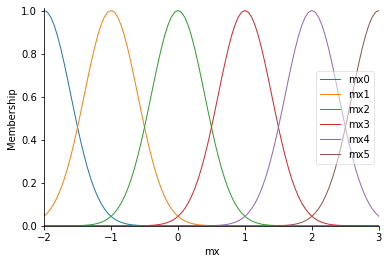

In [34]:
mx.view()

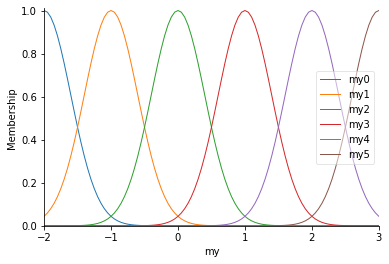

In [35]:
my.view()

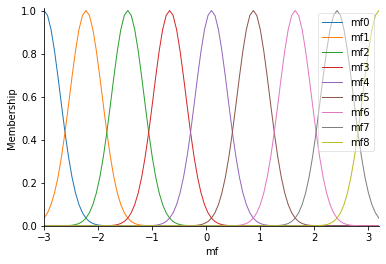

In [36]:
mf.view()

In [37]:
rules = []
for n_mf in range(9):
    # pairs of indice positions of Z_mf where Z_mf == n_mf:
    y_indices, x_indices = (Z_mf == n_mf).nonzero()
    if x_indices.size == 0:
        # no mf, so no rule for it
        continue
    
    # The antecedent:
    x_ind, y_ind = x_indices[0], y_indices[0]
    antecedent = mx[f'mx{x_ind}'] & my[f'my{y_ind}']
    for x_ind, y_ind in zip(x_indices[1:], y_indices[1:]):
        antecedent |= mx[f'mx{x_ind}'] & my[f'my{y_ind}']
        
    # The consequent:
    consequent = mf[f'mf{n_mf}']

    rule = ctrl.Rule(antecedent=antecedent,
                     consequent=consequent, 
                     label=f'rule mf{n_mf}')
    rules.append(rule)

In [38]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system)

In [39]:
new_Z = np.zeros((len(long_y), len(long_x)))
for j in range(len(long_y)):
    for i in range(len(long_x)):
        sim.inputs({'mx': long_x[i], 'my': long_y[j]})
        sim.compute()
        new_Z[j, i] = sim.output['mf']

In [40]:
# Графік
fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=new_Z)])

fig.update_layout(title='new_Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [41]:
# Діагональ (assuming x == y):
diag_Z = np.diag(long_Z)
diag_new_Z = np.diag(new_Z)
errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
error = round(errors.mean(), 3)

print('Error:', error, '%')

Error: 6.268 %


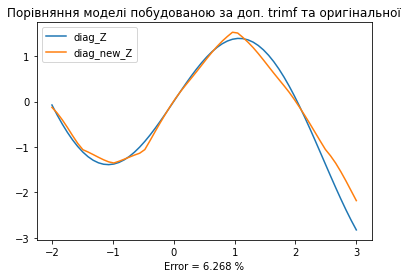

In [42]:
plt.plot(long_x, diag_Z)
plt.plot(long_x, diag_new_Z)
plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
plt.xlabel(f"Error = {error} %")
plt.legend(['diag_Z', 'diag_new_Z'])
plt.show()

### 3. Дослідити можливість зменшення числа правил за рахунок виключення деяких (перевірити достатність використання правил, що представляють тільки діагональ таблиці). 

In [43]:
rules = []
for n_mf in range(9):
    # only on the diagonal
    (x_indices,) = (np.diag(Z_mf) == n_mf).nonzero()
    if x_indices.size == 0:
        # no mf, so no rule for it
        continue
    
    # The antecedent:
    x_ind = x_indices[0]
    antecedent = mx[f'mx{x_ind}'] & my[f'my{x_ind}']
    for x_ind in x_indices[1:]:
        antecedent |= mx[f'mx{x_ind}'] & my[f'my{x_ind}']
    
    # The consequent:
    consequent = mf[f'mf{n_mf}']

    rule = ctrl.Rule(antecedent=antecedent,
                     consequent=consequent, 
                     label=f'rule mf{n_mf}')
    rules.append(rule)

In [44]:
system = ctrl.ControlSystem(rules=rules)
sim = ctrl.ControlSystemSimulation(system)

In [45]:
new_Z = np.zeros((len(long_y), len(long_x)))
for j in range(len(long_y)):
    for i in range(len(long_x)):
        sim.inputs({'mx': long_x[i], 'my': long_y[j]})
        sim.compute()
        new_Z[j, i] = sim.output['mf']

In [46]:
# Графік
fig = go.Figure(data=[go.Surface(x=long_x, y=long_y, z=new_Z)])

fig.update_layout(title='new_Z',
                  width=800, height=600, margin=dict(t=50, b=0, l=0, r=0))
fig.update_layout(template='plotly_dark')  # dark mode
fig.update_scenes(
    yaxis = dict(autorange = 'reversed'),  # reverse y axis
    aspectmode='cube'  # same aspect ratio for all 3 axes
)
fig.show()

In [47]:
# Діагональ (assuming x == y):
diag_Z = np.diag(long_Z)
diag_new_Z = np.diag(new_Z)
errors = np.abs(diag_Z - diag_new_Z) / (np.abs(diag_Z) + 1) * 100
error = round(errors.mean(), 3)

print('Error:', error, '%')

Error: 11.044 %


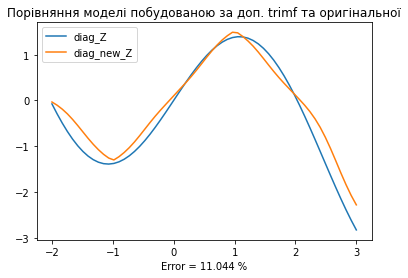

In [48]:
plt.plot(long_x, diag_Z)
plt.plot(long_x, diag_new_Z)
plt.title("Порівняння моделі побудованою за доп. trimf та оригінальної")
plt.xlabel(f"Error = {error} %")
plt.legend(['diag_Z', 'diag_new_Z'])
plt.show()